# Feature Engineering

Overview
Create features for anomaly detection including channel behavior and location analysis.
Feature Engineering Notebook
Overview
This notebook creates advanced features for anomaly detection based on the data exploration insights.

# Features to Engineer:
1. *Customer Behavior Features*: Frequency, recency, monetary value
2. *Channel Behavior Features*: Channel preferences and deviations
3. *Geographic Features*: Location patterns and distance calculations
4. *Temporal Features*: Time-based patterns and seasonality
5. *Transaction Pattern Features*: Amount distributions and volatility
6. *Anomaly Scores*: Statistical measures for outlier detection


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# For geographic calculations
from math import radians, sin, cos, sqrt, atan2
import haversine as hs
from haversine import haversine

# For statistical features
from scipy import stats
from scipy.stats import zscore, skew, kurtosis

# Set visualization styles
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# For better display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [2]:
# Load the cleaned data from exploration
try:
    df = pd.read_csv('../data/outputs/cleaned_exploration1_data.csv')
    print(f"✅ Cleaned data loaded successfully! Shape: {df.shape}")
except FileNotFoundError:
    # Fallback to processed data
    try:
        df = pd.read_csv('../data/outputs/cleaned_exploration1_data.csv')
        print(f"✅ Preprocessed data loaded! Shape: {df.shape}")
    except FileNotFoundError:
        # Fallback to raw data
        df = pd.read_csv('../data/raw/joined_table.csv')
        print(f"⚠️ Using raw data! Shape: {df.shape}")

# Display first few rows
print("\n📋 First 3 rows:")
display(df.head(3))

✅ Cleaned data loaded successfully! Shape: (1138311, 24)

📋 First 3 rows:


,Account_Number,Customer_Branch_Code,Branch_Name,Longitude,Latitude,End_of_Month,Current_Balance_LCY,Transaction_Amount,Last_Debit_Transaction_Date,Last_Credit_Transaction_Date,Transaction_Channel_Name,Channel_Category,Is_Channel_Flag,Total_Transaction_Count,Debit_Credit_Flag,Region,Transaction_Date,Transaction_Year,Transaction_Month,Transaction_Day,Transaction_Weekday,Transaction_Hour,Transaction_Date_Only,Transaction_Week
0,2045320689130240,1,Ridge Tower,-0.2002,5.5597,2025-03-31,1043797061,30930000.0000,2025-03-27 21:56:04,2025-03-27 20:01:18,Branch/Teller Username,Branch/Teller,0.0000,1.0000,D,Greater Accra Region,2025-03-27 21:56:04,2025,3,27,Thursday,21,2025-03-27,13
1,2045320689130240,1,Ridge Tower,-0.2002,5.5597,2025-03-31,1043797061,14434000.0000,2025-03-27 14:40:37,2025-03-27 07:55:46,System User,System/Service User,1.0000,1.0000,D,Greater Accra Region,2025-03-27 14:40:37,2025,3,27,Thursday,14,2025-03-27,13
2,2045320689130240,1,Ridge Tower,-0.2002,5.5597,2025-03-31,1043797061,1031000.0000,2025-03-27 04:52:29,2025-03-27 10:48:47,Branch/Teller Username,Branch/Teller,0.0000,1.0000,D,Greater Accra Region,2025-03-27 04:52:29,2025,3,27,Thursday,4,2025-03-27,13


In [3]:
# Check current columns
print(f"\n📊 Current dataset shape: {df.shape}")
print(f"Columns ({len(df.columns)}):")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2d}. {col}")


📊 Current dataset shape: (1138311, 24)
Columns (24):
   1. Account_Number
   2. Customer_Branch_Code
   3. Branch_Name
   4. Longitude
   5. Latitude
   6. End_of_Month
   7. Current_Balance_LCY
   8. Transaction_Amount
   9. Last_Debit_Transaction_Date
  10. Last_Credit_Transaction_Date
  11. Transaction_Channel_Name
  12. Channel_Category
  13. Is_Channel_Flag
  14. Total_Transaction_Count
  15. Debit_Credit_Flag
  16. Region
  17. Transaction_Date
  18. Transaction_Year
  19. Transaction_Month
  20. Transaction_Day
  21. Transaction_Weekday
  22. Transaction_Hour
  23. Transaction_Date_Only
  24. Transaction_Week


# Data Preparation
# 2.1 Ensure Proper Data Types
# Convert columns to correct data types for feature engineering.
#

In [4]:
print("🔄 CONVERTING DATA TYPES")
print("="*60)

# Convert date columns
date_columns = ['Transaction_Date', 'Last_Debit_Transaction_Date', 
                'Last_Credit_Transaction_Date', 'End_of_Month']
for col in date_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')
        print(f"Converted {col} to datetime")

# Convert numeric columns
numeric_columns = ['Current_Balance_LCY', 'Transaction_Amount', 
                   'Total_Transaction_Count', 'Longitude', 'Latitude']
for col in numeric_columns:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        print(f"Converted {col} to numeric")

# Convert categorical columns
categorical_columns = ['Transaction_Channel_Name', 'Debit_Credit_Flag', 
                       'Channel', 'Community', 'Region']
for col in categorical_columns:
    if col in df.columns:
        df[col] = df[col].astype('category')
        print(f"Converted {col} to category")

print("\n✅ Data types converted successfully")

🔄 CONVERTING DATA TYPES
Converted Transaction_Date to datetime
Converted Last_Debit_Transaction_Date to datetime
Converted Last_Credit_Transaction_Date to datetime
Converted End_of_Month to datetime
Converted Current_Balance_LCY to numeric
Converted Transaction_Amount to numeric
Converted Total_Transaction_Count to numeric
Converted Longitude to numeric
Converted Latitude to numeric
Converted Transaction_Channel_Name to category
Converted Debit_Credit_Flag to category
Converted Region to category

✅ Data types converted successfully



# 2.2 Handle Missing Values
# Fill missing values before feature engineering.

In [5]:
print("\n🔍 HANDLING MISSING VALUES")
print("="*60)

# Check missing values before handling
missing_before = df.isnull().sum().sum()
print(f"Missing values before handling: {missing_before:,}")

# Fill missing numeric values with 0
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(0)

# Fill missing categorical values - handle categorical types properly
categorical_cols = df.select_dtypes(include=['category', 'object']).columns

for col in categorical_cols:
    if df[col].dtype.name == 'category':
        # For categorical dtype, add 'Unknown' to categories first
        if 'Unknown' not in df[col].cat.categories:
            df[col] = df[col].cat.add_categories(['Unknown'])
        df[col] = df[col].fillna('Unknown')
    else:
        # For object dtype (strings), just fillna
        df[col] = df[col].fillna('Unknown')
    
    # Optional: Convert back to category if needed
    # df[col] = df[col].astype('category')

# For dates, fill with the most recent date or forward fill
date_cols = df.select_dtypes(include=['datetime64']).columns
for col in date_cols:
    if df[col].isnull().any():
        # Fill with the most recent date in the dataset
        df[col] = df[col].fillna(df[col].max())
        print(f"Filled missing dates in {col}")

missing_after = df.isnull().sum().sum()
print(f"Missing values after handling: {missing_after:,}")
print(f"Reduced by: {missing_before - missing_after:,} values")


🔍 HANDLING MISSING VALUES
Missing values before handling: 26,208
Missing values after handling: 0
Reduced by: 26,208 values


# 3.1 Basic Customer-Level Features
Create RFM (Recency, Frequency, Monetary) features.

In [6]:
print("👤 CUSTOMER BEHAVIOR FEATURES")
print("="*60)

# Create customer behavior features
if 'Account_Number' in df.columns and 'Transaction_Date' in df.columns:
    # Get the latest date for recency calculation
    max_date = df['Transaction_Date'].max()
    
    # Create customer-level features
    customer_features = df.groupby('Account_Number').agg({
        'Transaction_Date': ['min', 'max', 'count'],
        'Transaction_Amount': ['sum', 'mean', 'std', 'min', 'max'],
        'Transaction_Channel_Name': 'nunique',
        'Customer_Branch_Code': 'nunique',
        'Debit_Credit_Flag': lambda x: (x == 'D').sum()  # Count of debit transactions
    }).reset_index()
    
    # Flatten column names
    customer_features.columns = [
        'Account_Number',
        'First_Transaction_Date',
        'Last_Transaction_Date',
        'Transaction_Frequency',  # Total transactions
        'Total_Transaction_Amount',
        'Avg_Transaction_Amount',
        'Std_Transaction_Amount',
        'Min_Transaction_Amount',
        'Max_Transaction_Amount',
        'Unique_Channels_Used',
        'Unique_Branches_Used',
        'Debit_Transaction_Count'
    ]
    
    # Calculate additional features
    customer_features['Customer_Lifetime_Days'] = (
        customer_features['Last_Transaction_Date'] - 
        customer_features['First_Transaction_Date']
    ).dt.days + 1  # Add 1 to avoid division by zero
    
    # Recency: Days since last transaction
    customer_features['Recency_Days'] = (
        max_date - customer_features['Last_Transaction_Date']
    ).dt.days
    
    # Monetary: Average daily spend
    customer_features['Avg_Daily_Spend'] = (
        customer_features['Total_Transaction_Amount'] / 
        customer_features['Customer_Lifetime_Days']
    )
    
    # Frequency: Transactions per day
    customer_features['Transactions_Per_Day'] = (
        customer_features['Transaction_Frequency'] / 
        customer_features['Customer_Lifetime_Days']
    )
    
    # Transaction amount volatility (CV)
    customer_features['Amount_Coefficient_Variation'] = (
        customer_features['Std_Transaction_Amount'] / 
        customer_features['Avg_Transaction_Amount']
    ).replace([np.inf, -np.inf], 0)
    
    # Debit ratio
    customer_features['Debit_Ratio'] = (
        customer_features['Debit_Transaction_Count'] / 
        customer_features['Transaction_Frequency']
    )
    
    # Channel diversity score (0-1)
    customer_features['Channel_Diversity_Score'] = (
        customer_features['Unique_Channels_Used'] / 
        df['Transaction_Channel_Name'].nunique()
    )
    
    # Branch diversity score (0-1)
    if 'Customer_Branch_Code' in df.columns:
        customer_features['Branch_Diversity_Score'] = (
            customer_features['Unique_Branches_Used'] / 
            df['Customer_Branch_Code'].nunique()
        )
    
    print(f"Created customer features for {len(customer_features):,} unique customers")
    print("\n📊 Customer Features Sample:")
    display(customer_features.head())
    
    # Save customer features for later merge
    customer_features_df = customer_features.copy()
else:
    print("⚠️ Required columns not found for customer features")
    customer_features_df = pd.DataFrame()

👤 CUSTOMER BEHAVIOR FEATURES
Created customer features for 3,230 unique customers

📊 Customer Features Sample:


,Account_Number,First_Transaction_Date,Last_Transaction_Date,Transaction_Frequency,Total_Transaction_Amount,Avg_Transaction_Amount,Std_Transaction_Amount,Min_Transaction_Amount,Max_Transaction_Amount,Unique_Channels_Used,Unique_Branches_Used,Debit_Transaction_Count,Customer_Lifetime_Days,Recency_Days,Avg_Daily_Spend,Transactions_Per_Day,Amount_Coefficient_Variation,Debit_Ratio,Channel_Diversity_Score,Branch_Diversity_Score
0,2045320689130240,2025-03-27 00:11:17,2025-10-03 23:42:36,1352,43290381976.0000,32019513.2959,103089983.7029,5155.0000,1031000000.0000,8,1,0,191,27,226651214.5340,7.0785,3.2196,0.0000,0.3478,0.0106
1,2046245249449165,2025-02-03 00:02:56,2025-10-28 23:53:38,2210,23500074160.0000,10633517.7195,40028562.0798,0.0000,352292752.0000,12,1,0,268,2,87686843.8806,8.2463,3.7644,0.0000,0.5217,0.0106
2,2085813222758815,2024-11-01 00:00:47,2025-10-30 23:53:53,3553,368099995999.6000,103602588.2352,394235747.5939,-211521865.2500,4969420000.0000,9,1,0,364,0,1011263725.2736,9.7610,3.8053,0.0000,0.3913,0.0106
3,2085817038065365,2025-02-03 00:04:37,2025-10-03 23:58:23,3806,15471243227.0000,4064961.4364,7706361.7758,31.0000,66808800.0000,10,1,0,243,27,63667667.6008,15.6626,1.8958,0.0000,0.4348,0.0106
4,2085819113485840,2025-01-22 00:00:29,2025-10-29 23:42:44,1111,7949037536.0000,7154849.2673,20650260.1101,1237.0000,135412200.0000,5,1,0,281,1,28288389.8078,3.9537,2.8862,0.0000,0.2174,0.0106


# Channel Behavior Features
4.1 Channel Preference Features 
Identify each customer's preferred channel and detect deviations.

In [7]:
print("\n🏦 CHANNEL BEHAVIOR FEATURES")
print("="*60)

if 'Transaction_Channel_Name' in df.columns and 'Account_Number' in df.columns:
    # 1. Most frequent channel per customer (mode channel)
    def get_mode_channel(channels):
        mode_result = channels.mode()
        return mode_result.iloc[0] if not mode_result.empty else 'Unknown'
    
    channel_preferences = df.groupby('Account_Number')['Transaction_Channel_Name'].agg(
        get_mode_channel
    ).reset_index()
    channel_preferences.columns = ['Account_Number', 'Preferred_Channel']
    
    # 2. Channel usage distribution
    channel_usage = df.groupby(['Account_Number', 'Transaction_Channel_Name']).size().unstack(fill_value=0)
    channel_usage_pct = channel_usage.div(channel_usage.sum(axis=1), axis=0)
    
    # 3. Channel entropy (measure of channel diversity)
    from scipy.stats import entropy
    
    def calculate_entropy(row):
        # Remove zero values for entropy calculation
        probs = row[row > 0]
        if len(probs) <= 1:
            return 0
        return entropy(probs, base=2)
    
    channel_usage['Channel_Entropy'] = channel_usage_pct.apply(calculate_entropy, axis=1)
    channel_usage['Channel_Entropy'] = channel_usage['Channel_Entropy'].fillna(0)
    
    # 4. Channel concentration (Herfindahl-Hirschman Index)
    channel_usage['Channel_HHI'] = (channel_usage_pct ** 2).sum(axis=1)
    
    # 5. Top 2 channel concentration
    def top_n_concentration(row, n=2):
        sorted_probs = row.sort_values(ascending=False)
        return sorted_probs.head(n).sum()
    
    channel_usage['Top2_Channel_Concentration'] = channel_usage_pct.apply(
        lambda x: top_n_concentration(x, 2), axis=1
    )
    
    # Merge channel features
    channel_features = channel_usage[['Channel_Entropy', 'Channel_HHI', 'Top2_Channel_Concentration']].reset_index()
    channel_features = channel_preferences.merge(channel_features, on='Account_Number', how='left')
    
    print(f"Created channel features for {len(channel_features):,} customers")
    print("\n📊 Channel Features Sample:")
    display(channel_features.head())
    
    # Save channel features for later merge
    channel_features_df = channel_features.copy()
else:
    print("⚠️ Required columns not found for channel features")
    channel_features_df = pd.DataFrame()


🏦 CHANNEL BEHAVIOR FEATURES
Created channel features for 3,230 customers

📊 Channel Features Sample:


,Account_Number,Preferred_Channel,Channel_Entropy,Channel_HHI,Top2_Channel_Concentration
0,2045320689130240,Branch/Teller Username,1.7835,0.3833,0.7456
1,2046245249449165,Mistral,2.3483,0.2595,0.6561
2,2085813222758815,System User,2.0562,0.3047,0.6935
3,2085817038065365,System User,2.1303,0.2620,0.6445
4,2085819113485840,System User,1.6826,0.4061,0.7624


# 4.2 Channel Deviation Detection 
Flag transactions that deviate from customer's normal channel behavior.

In [8]:
print("\n📊 CHANNEL DEVIATION DETECTION")
print("="*60)

if 'channel_features_df' in locals() and not channel_features_df.empty:
    # Merge preferred channel back to transaction data
    df = df.merge(
        channel_features_df[['Account_Number', 'Preferred_Channel']], 
        on='Account_Number', 
        how='left'
    )
    
    # Flag channel deviations
    df['Channel_Deviation'] = (
        df['Transaction_Channel_Name'] != df['Preferred_Channel']
    ).astype(int)
    
    # Calculate channel deviation rate per customer
    channel_deviation_rate = df.groupby('Account_Number')['Channel_Deviation'].mean().reset_index()
    channel_deviation_rate.columns = ['Account_Number', 'Channel_Deviation_Rate']
    
    # Add to channel features
    channel_features_df = channel_features_df.merge(
        channel_deviation_rate, 
        on='Account_Number', 
        how='left'
    )
    
    print(f"✅ Channel deviations calculated")
    print(f"📈 Overall channel deviation rate: {df['Channel_Deviation'].mean():.2%}")
    print("\n📊 Channel Deviation Sample:")
    display(df[['Account_Number', 'Transaction_Channel_Name', 'Preferred_Channel', 'Channel_Deviation']].head(10))
else:
    print("⚠️ Channel features not available for deviation calculation")
    print("📌 Make sure to run the previous cell (4.1 Channel Preference Features) first")


📊 CHANNEL DEVIATION DETECTION
✅ Channel deviations calculated
📈 Overall channel deviation rate: 40.93%

📊 Channel Deviation Sample:


,Account_Number,Transaction_Channel_Name,Preferred_Channel,Channel_Deviation
0,2045320689130240,Branch/Teller Username,Branch/Teller Username,0
1,2045320689130240,System User,Branch/Teller Username,1
2,2045320689130240,Branch/Teller Username,Branch/Teller Username,0
3,2045320689130240,Branch/Teller Username,Branch/Teller Username,0
4,2045320689130240,System User,Branch/Teller Username,1
5,2045320689130240,Interbank Interface,Branch/Teller Username,1
6,2045320689130240,System User,Branch/Teller Username,1
7,2045320689130240,System User,Branch/Teller Username,1
8,2045320689130240,System User,Branch/Teller Username,1
9,2045320689130240,System User,Branch/Teller Username,1


# Geographic Features
5.1 Location-Based Features 
Create features based on geographic patterns.

In [9]:
print("\n🌍 GEOGRAPHIC FEATURES")
print("="*60)

# geographic features engineering
if all(col in df.columns for col in ['Longitude', 'Latitude', 'Customer_Branch_Code']):
    
    # Helper function to calculate distance between two points (in km)
    def calculate_distance(lat1, lon1, lat2, lon2):
        # Convert decimal degrees to radians
        lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
        
        # Haversine formula
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * atan2(sqrt(a), sqrt(1-a))
        r = 6371  # Radius of earth in kilometers
        
        return r * c
    
    # 1. Determine home location (most frequent branch) for each customer
    def get_home_location(group):
        # Find most frequent branch
        if 'Customer_Branch_Code' in group.columns:
            mode_branch = group['Customer_Branch_Code'].mode()
            if not mode_branch.empty:
                home_branch = mode_branch.iloc[0]
                home_data = group[group['Customer_Branch_Code'] == home_branch].iloc[0]
                return pd.Series({
                    'Home_Branch_Code': home_branch,
                    'Home_Longitude': home_data['Longitude'],
                    'Home_Latitude': home_data['Latitude'],
                    'Home_Region': home_data.get('Region', 'Unknown'),
                    'Home_Community': home_data.get('Community', 'Unknown')
                })
        return pd.Series({
            'Home_Branch_Code': 'Unknown',
            'Home_Longitude': 0,
            'Home_Latitude': 0,
            'Home_Region': 'Unknown',
            'Home_Community': 'Unknown'
        })
    
    # Calculate home location for each customer
    home_locations = df.groupby('Account_Number').apply(get_home_location).reset_index()
    
    # 2. Calculate distance from home for each transaction
    df = df.merge(home_locations, on='Account_Number', how='left')
    
    # Calculate distance using vectorized operations
    def vectorized_distance(row):
        if (row['Longitude'] != 0 and row['Latitude'] != 0 and 
            row['Home_Longitude'] != 0 and row['Home_Latitude'] != 0):
            return calculate_distance(
                row['Latitude'], row['Longitude'],
                row['Home_Latitude'], row['Home_Longitude']
            )
        return 0
    
    df['Distance_From_Home_km'] = df.apply(vectorized_distance, axis=1)
    
    # 3. Flag location anomalies
    # Define thresholds (can be adjusted based on business rules)
    distance_threshold = df['Distance_From_Home_km'].quantile(0.95)  # 95th percentile
    df['Location_Anomaly'] = (df['Distance_From_Home_km'] > distance_threshold).astype(int)
    
    # 4. Create customer-level geographic features
    geographic_features = df.groupby('Account_Number').agg({
        'Distance_From_Home_km': ['mean', 'max', 'std'],
        'Location_Anomaly': 'sum',
        'Customer_Branch_Code': 'nunique',
        'Region': 'nunique'
    }).reset_index()
    
    # Flatten column names
    geographic_features.columns = [
        'Account_Number',
        'Avg_Distance_From_Home_km',
        'Max_Distance_From_Home_km',
        'Std_Distance_From_Home_km',
        'Location_Anomaly_Count',
        'Unique_Branches_Visited',
        'Unique_Regions_Visited'
    ]
    
    # Add location anomaly rate
    total_transactions = df.groupby('Account_Number').size().reset_index(name='Total_Transactions')
    geographic_features = geographic_features.merge(total_transactions, on='Account_Number', how='left')
    geographic_features['Location_Anomaly_Rate'] = (
        geographic_features['Location_Anomaly_Count'] / 
        geographic_features['Total_Transactions']
    )
    
    # Calculate geographic dispersion score
    geographic_features['Geographic_Dispersion_Score'] = (
        geographic_features['Unique_Branches_Visited'] * 
        geographic_features['Unique_Regions_Visited']
    ) / geographic_features['Total_Transactions']
    
    print(f"Created geographic features for {len(geographic_features):,} customers")
    print(f"Distance threshold for anomalies: {distance_threshold:.2f} km")
    print("\n📊 Geographic Features Sample:")
    display(geographic_features.head())
    
    # Save geographic features
    geographic_features_df = geographic_features.copy()
else:
    print("⚠️ Required columns not found for geographic features")
    geographic_features_df = pd.DataFrame()


🌍 GEOGRAPHIC FEATURES
Created geographic features for 3,230 customers
Distance threshold for anomalies: 0.00 km

📊 Geographic Features Sample:


,Account_Number,Avg_Distance_From_Home_km,Max_Distance_From_Home_km,Std_Distance_From_Home_km,Location_Anomaly_Count,Unique_Branches_Visited,Unique_Regions_Visited,Total_Transactions,Location_Anomaly_Rate,Geographic_Dispersion_Score
0,2045320689130240,0.0000,0.0000,0.0000,0,1,1,1352,0.0000,0.0007
1,2046245249449165,0.0000,0.0000,0.0000,0,1,1,2210,0.0000,0.0005
2,2085813222758815,0.0000,0.0000,0.0000,0,1,1,3553,0.0000,0.0003
3,2085817038065365,0.0000,0.0000,0.0000,0,1,1,3806,0.0000,0.0003
4,2085819113485840,0.0000,0.0000,0.0000,0,1,1,1111,0.0000,0.0009


# 6.1 Time-Based Features 
Create features based on transaction timing patterns.

In [10]:
print("\n⏰ TEMPORAL FEATURES")
print("="*60)

#
if 'Transaction_Date' in df.columns:
    # Extract temporal components
    df['Transaction_Hour'] = df['Transaction_Date'].dt.hour
    df['Transaction_Day'] = df['Transaction_Date'].dt.day
    df['Transaction_Weekday'] = df['Transaction_Date'].dt.day_name()
    df['Transaction_Month'] = df['Transaction_Date'].dt.month
    df['Transaction_Week'] = df['Transaction_Date'].dt.isocalendar().week
    
    # 1. Time of day categories
    def categorize_time(hour):
        if 5 <= hour < 12:
            return 'Morning'
        elif 12 <= hour < 17:
            return 'Afternoon'
        elif 17 <= hour < 21:
            return 'Evening'
        else:
            return 'Night'
    
    df['Time_Category'] = df['Transaction_Hour'].apply(categorize_time)
    
    # 2. Weekend vs weekday
    df['Is_Weekend'] = df['Transaction_Date'].dt.weekday >= 5
    
    # 3. Part of month (beginning, middle, end)
    df['Day_of_Month'] = df['Transaction_Date'].dt.day
    df['Month_Part'] = pd.cut(
        df['Day_of_Month'], 
        bins=[0, 10, 20, 31], 
        labels=['Beginning', 'Middle', 'End'], 
        right=False
    )
    
    # 4. Time between transactions
    df = df.sort_values(['Account_Number', 'Transaction_Date'])
    df['Time_Since_Last_Txn_Hours'] = df.groupby('Account_Number')['Transaction_Date'].diff().dt.total_seconds() / 3600
    
    # Fill first transaction with NaN or large value
    df['Time_Since_Last_Txn_Hours'] = df['Time_Since_Last_Txn_Hours'].fillna(24*30)  # 30 days
    
    # 5. Create customer-level temporal features
    temporal_features = df.groupby('Account_Number').agg({
        'Transaction_Hour': ['mean', 'std', lambda x: x.mode().iloc[0] if not x.mode().empty else 0],
        'Is_Weekend': 'mean',
        'Time_Since_Last_Txn_Hours': ['mean', 'std', 'min', 'max']
    }).reset_index()
    
    # Flatten column names
    temporal_features.columns = [
        'Account_Number',
        'Avg_Transaction_Hour',
        'Std_Transaction_Hour',
        'Mode_Transaction_Hour',
        'Weekend_Transaction_Ratio',
        'Avg_Time_Between_Txn_Hours',
        'Std_Time_Between_Txn_Hours',
        'Min_Time_Between_Txn_Hours',
        'Max_Time_Between_Txn_Hours'
    ]
    
    # 6. Temporal consistency score (lower std = more consistent)
    temporal_features['Temporal_Consistency_Score'] = 1 / (1 + temporal_features['Std_Transaction_Hour'])
    
    # 7. Preferred time category
    time_pref = df.groupby(['Account_Number', 'Time_Category']).size().unstack(fill_value=0)
    time_pref['Preferred_Time_Category'] = time_pref.idxmax(axis=1)
    time_pref = time_pref[['Preferred_Time_Category']].reset_index()
    
    temporal_features = temporal_features.merge(time_pref, on='Account_Number', how='left')
    
    print(f"Created temporal features for {len(temporal_features):,} customers")
    print("\n📊 Temporal Features Sample:")
    display(temporal_features.head())
    
    # Save temporal features
    temporal_features_df = temporal_features.copy()
else:
    print("⚠️ Transaction_Date column not found for temporal features")
    temporal_features_df = pd.DataFrame()


⏰ TEMPORAL FEATURES
Created temporal features for 3,230 customers

📊 Temporal Features Sample:


,Account_Number,Avg_Transaction_Hour,Std_Transaction_Hour,Mode_Transaction_Hour,Weekend_Transaction_Ratio,Avg_Time_Between_Txn_Hours,Std_Time_Between_Txn_Hours,Min_Time_Between_Txn_Hours,Max_Time_Between_Txn_Hours,Temporal_Consistency_Score,Preferred_Time_Category
0,2045320689130240,11.2456,6.8627,12,0.2500,3.9227,51.6999,0.0000,816.3906,0.1272,Night
1,2046245249449165,11.6186,6.9299,19,0.2000,3.2361,46.5596,0.0000,816.1789,0.1261,Night
2,2085813222758815,11.4714,6.8504,19,0.0000,2.6614,63.0240,0.0000,2616.1456,0.1274,Night
3,2085817038065365,11.5854,6.9938,20,0.0000,1.7215,34.0300,0.0000,816.2197,0.1251,Night
4,2085819113485840,11.6661,7.0241,20,0.0000,6.7180,107.0379,0.0000,2856.2061,0.1246,Night


# 7.1 Transaction Amount Features
Create features based on transaction amount patterns.


In [11]:
print("\n💰 TRANSACTION PATTERN FEATURES")
print("="*60)

# Create transaction pattern features
if 'Transaction_Amount' in df.columns and 'Account_Number' in df.columns:
    # 1. Statistical features for transaction amounts
    amount_features = df.groupby('Account_Number').agg({
        'Transaction_Amount': [
            'mean', 'std', 'min', 'max', 'median', 
            lambda x: x.quantile(0.25),  # Q1
            lambda x: x.quantile(0.75),  # Q3
            lambda x: x.skew(),          # Skewness
            lambda x: x.kurtosis()       # Kurtosis
        ]
    }).reset_index()
    
    # Flatten column names
    amount_features.columns = [
        'Account_Number',
        'Avg_Transaction_Amount',
        'Std_Transaction_Amount',
        'Min_Transaction_Amount',
        'Max_Transaction_Amount',
        'Median_Transaction_Amount',
        'Q1_Transaction_Amount',
        'Q3_Transaction_Amount',
        'Amount_Skewness',
        'Amount_Kurtosis'
    ]
    
    # 2. Calculate amount ranges and ratios
    amount_features['Amount_Range'] = (
        amount_features['Max_Transaction_Amount'] - 
        amount_features['Min_Transaction_Amount']
    )
    
    amount_features['IQR_Amount'] = (
        amount_features['Q3_Transaction_Amount'] - 
        amount_features['Q1_Transaction_Amount']
    )
    
    amount_features['Amount_CV'] = (
        amount_features['Std_Transaction_Amount'] / 
        amount_features['Avg_Transaction_Amount']
    ).replace([np.inf, -np.inf], 0)
    
    # 3. Flag for unusual amount patterns
    amount_features['High_Volatility_Flag'] = (
        amount_features['Amount_CV'] > 
        amount_features['Amount_CV'].quantile(0.75)
    ).astype(int)
    
    amount_features['High_Skewness_Flag'] = (
        abs(amount_features['Amount_Skewness']) > 2
    ).astype(int)
    
    # 4. Transaction size categories
    def categorize_amount(amount):
        if amount < 100:
            return 'Small'
        elif amount < 1000:
            return 'Medium'
        elif amount < 10000:
            return 'Large'
        else:
            return 'Very Large'
    
    df['Amount_Category'] = df['Transaction_Amount'].apply(categorize_amount)
    
    # Get amount category distribution
    amount_cat_dist = pd.crosstab(
        df['Account_Number'], 
        df['Amount_Category'], 
        normalize='index'
    ).reset_index()
    
    # Rename columns
    amount_cat_dist.columns = [
        'Account_Number',
        'Pct_Small_Transactions',
        'Pct_Medium_Transactions',
        'Pct_Large_Transactions',
        'Pct_Very_Large_Transactions'
    ]
    
    # Merge with amount features
    amount_features = amount_features.merge(amount_cat_dist, on='Account_Number', how='left')
    
    print(f"Created amount features for {len(amount_features):,} customers")
    print("\n📊 Amount Features Sample:")
    display(amount_features.head())
    
    # Save amount features
    amount_features_df = amount_features.copy()
else:
    print("⚠️ Transaction_Amount column not found for amount features")
    amount_features_df = pd.DataFrame()


💰 TRANSACTION PATTERN FEATURES
Created amount features for 3,230 customers

📊 Amount Features Sample:


,Account_Number,Avg_Transaction_Amount,Std_Transaction_Amount,Min_Transaction_Amount,Max_Transaction_Amount,Median_Transaction_Amount,Q1_Transaction_Amount,Q3_Transaction_Amount,Amount_Skewness,Amount_Kurtosis,Amount_Range,IQR_Amount,Amount_CV,High_Volatility_Flag,High_Skewness_Flag,Pct_Small_Transactions,Pct_Medium_Transactions,Pct_Large_Transactions,Pct_Very_Large_Transactions
0,2045320689130240,32019513.2959,103089983.7029,5155.0000,1031000000.0000,8541763.0000,2062000.0000,20620000.0000,7.4484,62.1850,1030994845.0000,18558000.0000,3.2196,1,1,0.0059,0.0000,0.0000,0.9941
1,2046245249449165,10633517.7195,40028562.0798,0.0000,352292752.0000,176136.0000,36085.0000,5155000.0000,6.7788,49.6527,352292752.0000,5118915.0000,3.7644,1,1,0.0769,0.0045,0.0045,0.9140
2,2085813222758815,103602588.2352,394235747.5939,-211521865.2500,4969420000.0000,251018.0000,51550.0000,30930000.0000,7.7840,78.3727,5180941865.2500,30878450.0000,3.8053,1,1,0.0124,0.0062,0.0031,0.9783
3,2085817038065365,4064961.4364,7706361.7758,31.0000,66808800.0000,303660.5000,36085.0000,5072520.0000,3.2262,15.5725,66808769.0000,5036435.0000,1.8958,0,1,0.0665,0.0260,0.0029,0.9046
4,2085819113485840,7154849.2673,20650260.1101,1237.0000,135412200.0000,510582.0000,72170.0000,3859445.0000,4.5946,22.0195,135410963.0000,3787275.0000,2.8862,1,1,0.0396,0.0000,0.0000,0.9604


# 8.1 Debit vs Credit Features
Create features based on debit/credit patterns.

In [12]:
print("\n⚖️ DEBIT/CREDIT PATTERN FEATURES")
print("="*60)

# Create debit/credit pattern features
if 'Debit_Credit_Flag' in df.columns and 'Account_Number' in df.columns:
    # 1. Basic debit/credit statistics
    debit_credit_features = df.groupby('Account_Number').agg({
        'Debit_Credit_Flag': [
            'count',
            lambda x: (x == 'D').sum(),  # Debit count
            lambda x: (x == 'C').sum(),  # Credit count
            lambda x: (x == 'D').mean()  # Debit ratio
        ],
        'Transaction_Amount': [
            lambda x: x[df['Debit_Credit_Flag'] == 'D'].sum() if 'D' in df['Debit_Credit_Flag'].values else 0,
            lambda x: x[df['Debit_Credit_Flag'] == 'C'].sum() if 'C' in df['Debit_Credit_Flag'].values else 0,
            lambda x: x[df['Debit_Credit_Flag'] == 'D'].mean() if 'D' in df['Debit_Credit_Flag'].values else 0,
            lambda x: x[df['Debit_Credit_Flag'] == 'C'].mean() if 'C' in df['Debit_Credit_Flag'].values else 0
        ]
    }).reset_index()
    
    # Flatten column names
    debit_credit_features.columns = [
        'Account_Number',
        'Total_Transactions',
        'Debit_Count',
        'Credit_Count',
        'Debit_Ratio',
        'Total_Debit_Amount',
        'Total_Credit_Amount',
        'Avg_Debit_Amount',
        'Avg_Credit_Amount'
    ]
    
    # 2. Calculate derived features
    debit_credit_features['Credit_Ratio'] = 1 - debit_credit_features['Debit_Ratio']
    debit_credit_features['Net_Flow'] = (
        debit_credit_features['Total_Credit_Amount'] - 
        debit_credit_features['Total_Debit_Amount']
    )
    
    debit_credit_features['Avg_Net_Flow_Per_Txn'] = (
        debit_credit_features['Net_Flow'] / 
        debit_credit_features['Total_Transactions']
    )
    
    debit_credit_features['Debit_Credit_Ratio_Amount'] = (
        debit_credit_features['Total_Debit_Amount'] / 
        (debit_credit_features['Total_Credit_Amount'] + 1e-10)  # Avoid division by zero
    )
    
    # 3. Transaction type patterns
    # Create sequence of transaction types
    df_sorted = df.sort_values(['Account_Number', 'Transaction_Date'])
    df_sorted['Txn_Type_Sequence'] = df_sorted.groupby('Account_Number')['Debit_Credit_Flag'].shift(1)
    
    # Calculate type switches (D->C or C->D)
    type_switches = df_sorted.groupby('Account_Number').apply(
        lambda x: (x['Debit_Credit_Flag'] != x['Txn_Type_Sequence']).sum()
    ).reset_index(name='Type_Switch_Count')
    
    # Merge with other features
    debit_credit_features = debit_credit_features.merge(type_switches, on='Account_Number', how='left')
    debit_credit_features['Type_Switch_Rate'] = (
        debit_credit_features['Type_Switch_Count'] / 
        debit_credit_features['Total_Transactions']
    )
    
    print(f"Created debit/credit features for {len(debit_credit_features):,} customers")
    print("\n📊 Debit/Credit Features Sample:")
    display(debit_credit_features.head())
    
    # Save debit/credit features
    debit_credit_features_df = debit_credit_features.copy()
else:
    print("⚠️ Debit_Credit_Flag column not found for debit/credit features")
    debit_credit_features_df = pd.DataFrame()


⚖️ DEBIT/CREDIT PATTERN FEATURES
Created debit/credit features for 3,230 customers

📊 Debit/Credit Features Sample:


,Account_Number,Total_Transactions,Debit_Count,Credit_Count,Debit_Ratio,Total_Debit_Amount,Total_Credit_Amount,Avg_Debit_Amount,Avg_Credit_Amount,Credit_Ratio,Net_Flow,Avg_Net_Flow_Per_Txn,Debit_Credit_Ratio_Amount,Type_Switch_Count,Type_Switch_Rate
0,2045320689130240,1352,0,0,0.0000,0,0,0,0,1.0000,0,0.0000,0.0000,321,0.2374
1,2046245249449165,2210,0,0,0.0000,0,0,0,0,1.0000,0,0.0000,0.0000,685,0.3100
2,2085813222758815,3553,0,0,0.0000,0,0,0,0,1.0000,0,0.0000,0.0000,1621,0.4562
3,2085817038065365,3806,0,0,0.0000,0,0,0,0,1.0000,0,0.0000,0.0000,1241,0.3261
4,2085819113485840,1111,0,0,0.0000,0,0,0,0,1.0000,0,0.0000,0.0000,445,0.4005


# 9.1 Combine All Features
Merge all engineered features into a single dataset.

In [13]:
print("🔄 MERGING ALL FEATURES")
print("="*60)

# Merge all features into a single dataset
# Start with customer features as base
if 'customer_features_df' in locals() and not customer_features_df.empty:
    all_features = customer_features_df.copy()
    print(f"Starting with {len(all_features):,} customer features")
else:
    # Create base from unique accounts
    all_features = pd.DataFrame({'Account_Number': df['Account_Number'].unique()})
    print(f"Starting with {len(all_features):,} unique accounts")

# List of all feature DataFrames to merge
feature_dfs = [
    ('channel', channel_features_df),
    ('geographic', geographic_features_df),
    ('temporal', temporal_features_df),
    ('amount', amount_features_df),
    ('debit_credit', debit_credit_features_df)
]

# Merge all features
for name, feature_df in feature_dfs:
    if feature_df is not None and not feature_df.empty:
        before_rows = len(all_features)
        all_features = all_features.merge(feature_df, on='Account_Number', how='left')
        added_cols = len(feature_df.columns) - 1  # Subtract Account_Number
        print(f"➕ Added {added_cols:2d} {name:12s} features | Rows: {before_rows:,} → {len(all_features):,}")
    else:
        print(f"⚠️  Skipping {name:12s} features (not available)")

print(f"\n✅ Final feature dataset shape: {all_features.shape}")
print(f"📊 Total features created: {len(all_features.columns)}")

# Display feature summary
print("\n📋 Feature Summary:")
for i, col in enumerate(all_features.columns, 1):
    dtype = str(all_features[col].dtype)
    unique = all_features[col].nunique()
    missing = all_features[col].isnull().sum()
    print(f"{i:3d}. {col:40s} | {dtype:10s} | Unique: {unique:6d} | Missing: {missing:6d}")

🔄 MERGING ALL FEATURES
Starting with 3,230 customer features
➕ Added  5 channel      features | Rows: 3,230 → 3,230
➕ Added  9 geographic   features | Rows: 3,230 → 3,230
➕ Added 10 temporal     features | Rows: 3,230 → 3,230
➕ Added 18 amount       features | Rows: 3,230 → 3,230
➕ Added 14 debit_credit features | Rows: 3,230 → 3,230

✅ Final feature dataset shape: (3230, 76)
📊 Total features created: 76

📋 Feature Summary:
  1. Account_Number                           | int64      | Unique:   3230 | Missing:      0
  2. First_Transaction_Date                   | datetime64[ns] | Unique:   3211 | Missing:      0
  3. Last_Transaction_Date                    | datetime64[ns] | Unique:   3214 | Missing:      0
  4. Transaction_Frequency                    | int64      | Unique:    525 | Missing:      0
  5. Total_Transaction_Amount                 | float64    | Unique:   2090 | Missing:      0
  6. Avg_Transaction_Amount_x                 | float64    | Unique:   1978 | Missing:      0


# 10.1 Handle Missing Values in Features
Fill missing values in the final feature dataset.

In [14]:
print("\n🔍 HANDLING MISSING VALUES IN FEATURES")
print("="*60)

# Check missing values
missing_summary = pd.DataFrame({
    'Column': all_features.columns,
    'Missing_Count': all_features.isnull().sum().values,
    'Missing_Percentage': (all_features.isnull().sum() / len(all_features) * 100).values
}).sort_values('Missing_Percentage', ascending=False)

print("Missing values before handling:")
display(missing_summary[missing_summary['Missing_Count'] > 0].head(10))

# Fill missing values
# For numeric columns, fill with median
numeric_cols = all_features.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if all_features[col].isnull().any():
        median_val = all_features[col].median()
        all_features[col] = all_features[col].fillna(median_val)
        print(f"Filled {col} with median: {median_val:.4f}")

# For categorical columns, fill with mode
categorical_cols = all_features.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    if all_features[col].isnull().any():
        mode_val = all_features[col].mode().iloc[0] if not all_features[col].mode().empty else 'Unknown'
        all_features[col] = all_features[col].fillna(mode_val)
        print(f"Filled {col} with mode: {mode_val}")

print(f"\n✅ Missing values after handling: {all_features.isnull().sum().sum()}")


🔍 HANDLING MISSING VALUES IN FEATURES
Missing values before handling:


,Column,Missing_Count,Missing_Percentage
55,Amount_CV,425,13.1579
16,Amount_Coefficient_Variation,425,13.1579
52,Amount_Kurtosis,56,1.7337
51,Amount_Skewness,46,1.4241
35,Std_Transaction_Hour,14,0.4334
39,Std_Time_Between_Txn_Hours,14,0.4334
27,Std_Distance_From_Home_km,14,0.4334
42,Temporal_Consistency_Score,14,0.4334
6,Std_Transaction_Amount_x,14,0.4334
45,Std_Transaction_Amount_y,14,0.4334


Filled Std_Transaction_Amount_x with median: 56669.5744
Filled Amount_Coefficient_Variation with median: 1.3740
Filled Std_Distance_From_Home_km with median: 0.0000
Filled Std_Transaction_Hour with median: 6.9156
Filled Std_Time_Between_Txn_Hours with median: 110.8315
Filled Temporal_Consistency_Score with median: 0.1263
Filled Std_Transaction_Amount_y with median: 56669.5744
Filled Amount_Skewness with median: 1.0035
Filled Amount_Kurtosis with median: 0.0000
Filled Amount_CV with median: 1.3740

✅ Missing values after handling: 0


# 10.2 Feature Scaling
Scale numeric features for better model performance.

In [15]:
print("\n📏 FEATURE SCALING")
print("="*60)

# Scale numeric features using different techniques
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Identify numeric columns to scale (excluding identifiers and dates)
exclude_cols = ['Account_Number', 'First_Transaction_Date', 'Last_Transaction_Date']
numeric_to_scale = [col for col in numeric_cols if col not in exclude_cols]

print(f"Scaling {len(numeric_to_scale)} numeric features...")

# Create a copy of original features for reference
features_original = all_features.copy()

# Apply different scaling techniques
scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler(feature_range=(0, 1))
scaler_robust = RobustScaler()

# Scale features
features_standard = pd.DataFrame(
    scaler_standard.fit_transform(all_features[numeric_to_scale]),
    columns=[f"{col}_std" for col in numeric_to_scale],
    index=all_features.index
)

features_minmax = pd.DataFrame(
    scaler_minmax.fit_transform(all_features[numeric_to_scale]),
    columns=[f"{col}_minmax" for col in numeric_to_scale],
    index=all_features.index
)

features_robust = pd.DataFrame(
    scaler_robust.fit_transform(all_features[numeric_to_scale]),
    columns=[f"{col}_robust" for col in numeric_to_scale],
    index=all_features.index
)

# Combine scaled features with original non-scaled columns
all_features_scaled = pd.concat([
    all_features[['Account_Number'] + [col for col in all_features.columns if col not in numeric_to_scale]],
    features_standard,
    features_minmax,
    features_robust
], axis=1)

print(f"✅ Scaled features shape: {all_features_scaled.shape}")
print(f"📊 Original features preserved, scaled versions added with suffixes (_std, _minmax, _robust)")

# Display sample of scaled features
print("\n📋 Scaled Features Sample (first 5 scaled columns):")
scaled_cols = [col for col in all_features_scaled.columns if any(x in col for x in ['_std', '_minmax', '_robust'])]
display(all_features_scaled[['Account_Number'] + scaled_cols[:5]].head())


📏 FEATURE SCALING
Scaling 71 numeric features...
✅ Scaled features shape: (3230, 219)
📊 Original features preserved, scaled versions added with suffixes (_std, _minmax, _robust)

📋 Scaled Features Sample (first 5 scaled columns):


,Account_Number,Account_Number,Transaction_Frequency_std,Total_Transaction_Amount_std,Avg_Transaction_Amount_x_std,Std_Transaction_Amount_x_std,Min_Transaction_Amount_x_std
0,2045320689130240,2045320689130240,1.6534,0.5029,0.8367,0.8033,0.0336
1,2046245249449165,2046245249449165,3.0727,0.2305,0.1996,0.2580,0.0333
2,2085813222758815,2085813222758815,5.2942,4.9733,2.9691,3.3212,-9.7104
3,2085817038065365,2085817038065365,5.7127,0.1200,0.0039,-0.0215,0.0333
4,2085819113485840,2085819113485840,1.2548,0.0165,0.0960,0.0904,0.0334


# 11.1 Correlation Analysis
Identify highly correlated features for potential removal.


🔗 FEATURE CORRELATION ANALYSIS
Found 49 feature pairs with correlation > 0.8

📊 Highly Correlated Feature Pairs:
  • Transaction_Frequency          ↔ Total_Transactions_x          : 1.0000
  • Transaction_Frequency          ↔ Total_Transactions_y          : 1.0000
  • Transaction_Frequency          ↔ Type_Switch_Count             : 0.9645
  • Total_Transaction_Amount       ↔ Avg_Transaction_Amount_x      : 0.8041
  • Total_Transaction_Amount       ↔ Avg_Transaction_Amount_y      : 0.8041
  • Avg_Transaction_Amount_x       ↔ Std_Transaction_Amount_x      : 0.8993
  • Avg_Transaction_Amount_x       ↔ Max_Transaction_Amount_x      : 0.8366
  • Avg_Transaction_Amount_x       ↔ Avg_Transaction_Amount_y      : 1.0000
  • Avg_Transaction_Amount_x       ↔ Std_Transaction_Amount_y      : 0.8993
  • Avg_Transaction_Amount_x       ↔ Max_Transaction_Amount_y      : 0.8366


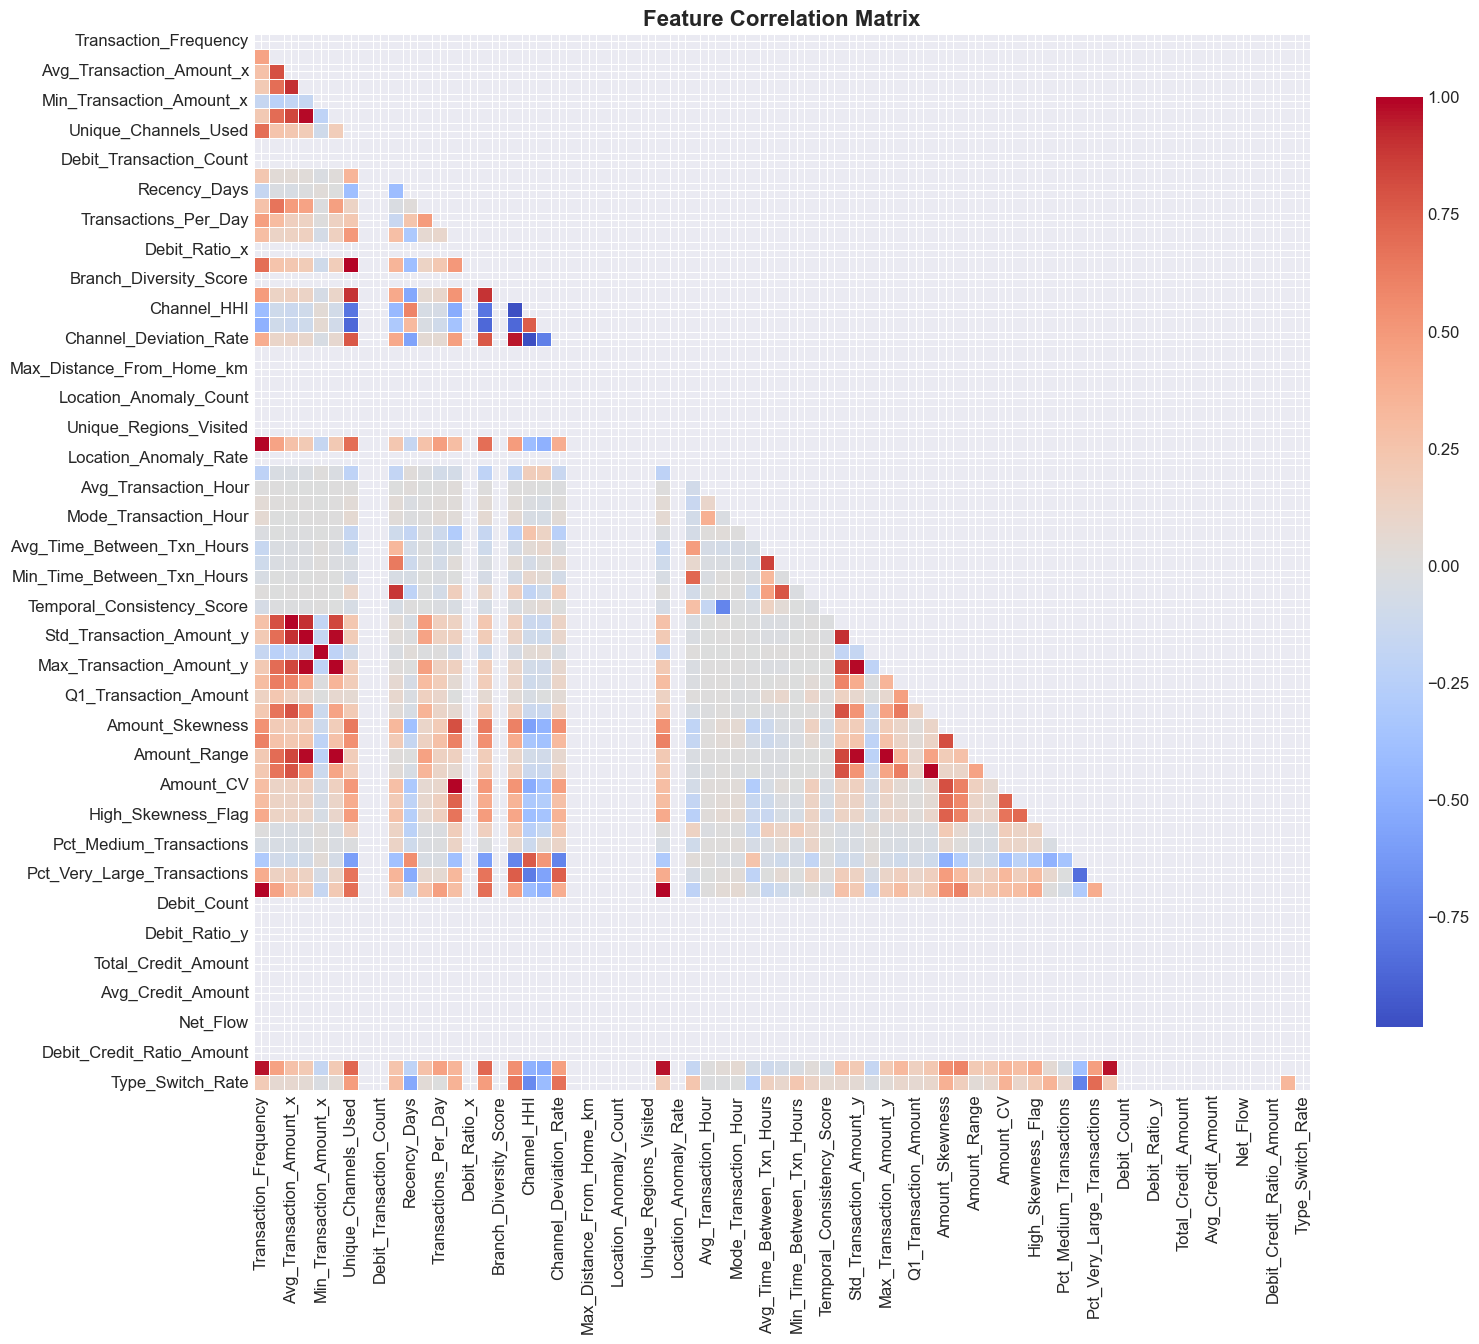

In [16]:
print("\n🔗 FEATURE CORRELATION ANALYSIS")
print("="*60)

# Calculate correlation matrix (using original numeric features)
correlation_matrix = all_features[numeric_to_scale].corr()

# Find highly correlated feature pairs
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:  # Threshold for high correlation
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

print(f"Found {len(high_corr_pairs)} feature pairs with correlation > 0.8")
if high_corr_pairs:
    print("\n📊 Highly Correlated Feature Pairs:")
    for feat1, feat2, corr in high_corr_pairs[:10]:  # Show top 10
        print(f"  • {feat1:30s} ↔ {feat2:30s}: {corr:.4f}")
else:
    print("✅ No highly correlated feature pairs found")

# Visualize correlation matrix
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# 11.2 Feature Importance (using Tree-based model)
Use Random Forest to estimate feature importance.


🎯 FEATURE IMPORTANCE ANALYSIS
Trained Random Forest for feature importance (R²: 0.9770)

📊 Top 20 Most Important Features:


,Feature,Importance
1,Total_Transaction_Amount,0.8731
40,Std_Transaction_Amount_y,0.0177
3,Std_Transaction_Amount_x,0.0120
39,Avg_Transaction_Amount_y,0.0119
43,Median_Transaction_Amount,0.0114
56,Pct_Very_Large_Transactions,0.0079
15,Channel_Diversity_Score,0.0076
6,Unique_Channels_Used,0.0073
17,Channel_Entropy,0.0070
18,Channel_HHI,0.0054


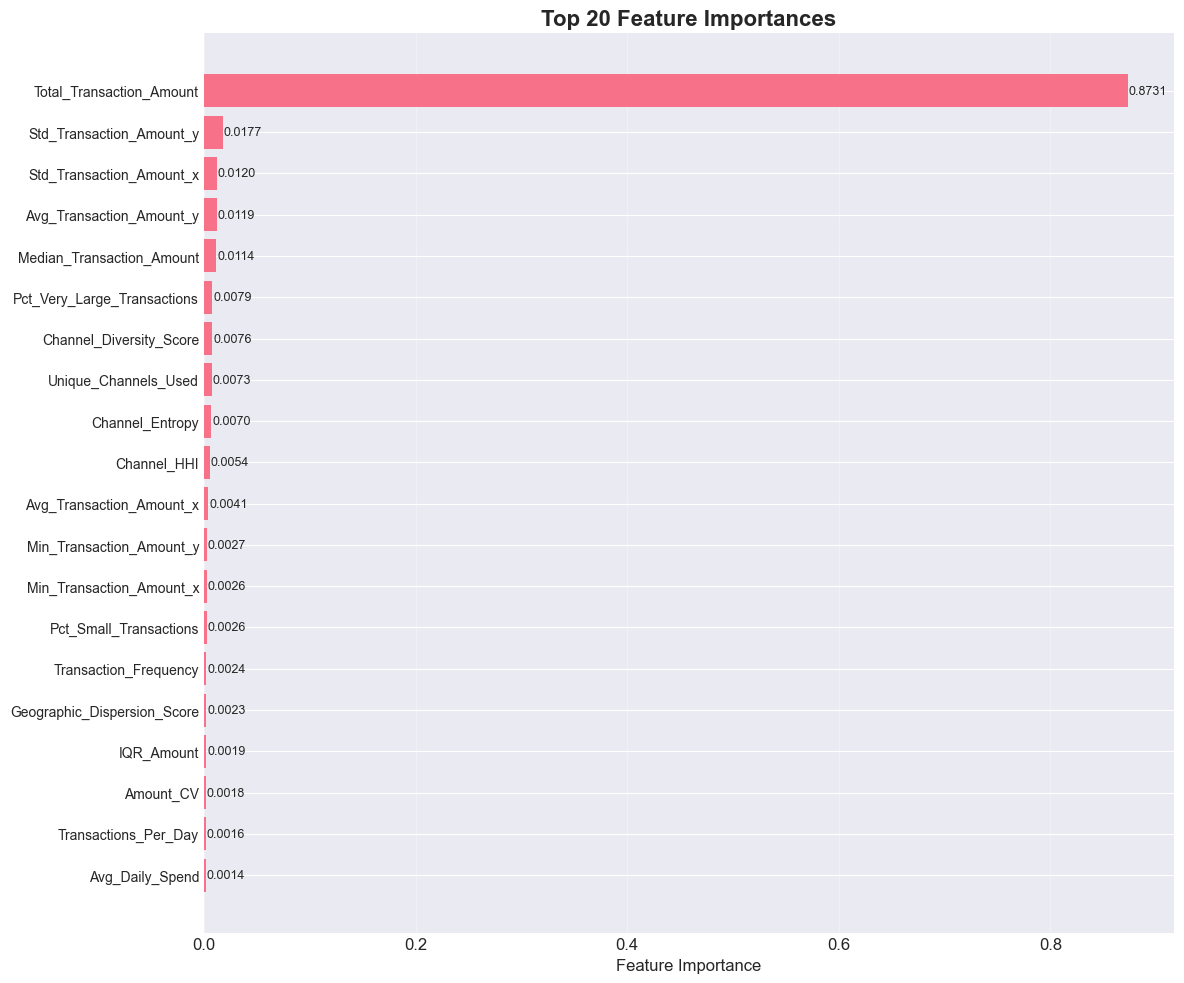

✅ Feature importance saved to: ../data/outputs/feature_importance.csv


In [17]:
print("\n🎯 FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Use Random Forest to estimate feature importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Prepare data for feature importance (using a simple target)
# For demonstration, use Total_Transaction_Amount as target
if 'Total_Transaction_Amount' in all_features.columns:
    # Prepare features and target
    X = all_features[numeric_to_scale].fillna(0)
    y = all_features['Total_Transaction_Amount'].fillna(0)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Train Random Forest
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    # Get feature importance
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': rf.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print(f"Trained Random Forest for feature importance (R²: {rf.score(X_test, y_test):.4f})")
    print("\n📊 Top 20 Most Important Features:")
    display(importance_df.head(20))
    
    # Visualize feature importance
    plt.figure(figsize=(12, 10))
    top_n = 20
    top_features = importance_df.head(top_n)
    
    bars = plt.barh(range(top_n), top_features['Importance'][::-1])
    plt.yticks(range(top_n), top_features['Feature'][::-1], fontsize=10)
    plt.xlabel('Feature Importance', fontsize=12)
    plt.title(f'Top {top_n} Feature Importances', fontsize=16, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
                f'{width:.4f}', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Save feature importance
    importance_path = '../data/outputs/feature_importance.csv'
    importance_df.to_csv(importance_path, index=False)
    print(f"✅ Feature importance saved to: {importance_path}")
else:
    print("⚠️ Could not calculate feature importance (missing target column)")

# 12.1 Export Engineered Features
Save all features for use in anomaly detection.

In [18]:
print("\n💾 EXPORTING ENGINEERED FEATURES")
print("="*60)

# Export engineered features
import os

# Create output directory if it doesn't exist
output_dir = '../data/outputs'
os.makedirs(output_dir, exist_ok=True)

# 1. Save original features
original_features_path = f'{output_dir}/customer_features_original1.csv'
all_features.to_csv(original_features_path, index=False)
print(f"✅ Original features saved to: {original_features_path}")

# 2. Save scaled features
scaled_features_path = f'{output_dir}/customer_features_scaled1.csv'
all_features_scaled.to_csv(scaled_features_path, index=False)
print(f"✅ Scaled features saved to: {scaled_features_path}")

# 3. Save feature descriptions
feature_descriptions = []
for col in all_features.columns:
    if col in numeric_cols:
        desc = f"Numeric feature: {col}"
        if 'Avg' in col:
            desc += " - Average value"
        elif 'Std' in col:
            desc += " - Standard deviation"
        elif 'Ratio' in col or 'Rate' in col:
            desc += " - Ratio or percentage"
        elif 'Count' in col:
            desc += " - Count of occurrences"
        elif 'Amount' in col:
            desc += " - Monetary amount"
    elif col in categorical_cols:
        desc = f"Categorical feature: {col}"
    else:
        desc = f"Other feature: {col}"
    
    feature_descriptions.append({'Feature': col, 'Description': desc})

description_df = pd.DataFrame(feature_descriptions)
description_path = f'{output_dir}/feature_descriptions.csv'
description_df.to_csv(description_path, index=False)
print(f"✅ Feature descriptions saved to: {description_path}")

# 4. Save summary statistics
summary_stats = pd.DataFrame({
    'Statistic': [
        'Number of Customers',
        'Number of Features',
        'Number of Numeric Features',
        'Number of Categorical Features',
        'Average Transactions per Customer',
        'Average Transaction Amount',
        'Total Transaction Volume'
    ],
    'Value': [
        len(all_features),
        len(all_features.columns),
        len(numeric_cols),
        len(categorical_cols),
        all_features['Transaction_Frequency'].mean() if 'Transaction_Frequency' in all_features.columns else 'N/A',
        all_features['Avg_Transaction_Amount'].mean() if 'Avg_Transaction_Amount' in all_features.columns else 'N/A',
        all_features['Total_Transaction_Amount'].sum() if 'Total_Transaction_Amount' in all_features.columns else 'N/A'
    ]
})

summary_path = f'{output_dir}/feature_engineering_summary.csv'
summary_stats.to_csv(summary_path, index=False)
print(f"✅ Summary statistics saved to: {summary_path}")


💾 EXPORTING ENGINEERED FEATURES
✅ Original features saved to: ../data/outputs/customer_features_original1.csv
✅ Scaled features saved to: ../data/outputs/customer_features_scaled1.csv
✅ Feature descriptions saved to: ../data/outputs/feature_descriptions.csv
✅ Summary statistics saved to: ../data/outputs/feature_engineering_summary.csv


13.1 Recommendations for Anomaly Detection
Based on the engineered features, here are recommended next steps.


In [19]:
print("\n🚀 RECOMMENDED NEXT STEPS FOR ANOMALY DETECTION")
print("="*60)

# Provide recommendations for next steps
recommendations = [
    "1. **Feature Selection for Modeling**:",
    "   - Use the top 20-30 most important features from Random Forest analysis",
    "   - Remove highly correlated features (correlation > 0.8)",
    "   - Consider domain knowledge for feature selection",
    "",
    "2. **Anomaly Detection Algorithms to Try**:",
    "   - **Isolation Forest**: Good for high-dimensional data",
    "   - **Local Outlier Factor (LOF)**: Good for local density-based anomalies",
    "   - **One-Class SVM**: Good for novelty detection",
    "   - **Autoencoders**: Deep learning approach for complex patterns",
    "",
    "3. **Key Anomaly Indicators Identified**:",
    "   - **Channel Deviation Rate**: Customers suddenly using different channels",
    "   - **Location Anomaly Rate**: Transactions far from home location",
    "   - **High Transaction Volatility**: Unusual amount variations",
    "   - **Atypical Temporal Patterns**: Transactions at unusual hours",
    "   - **Unusual Debit/Credit Patterns**: Abnormal transaction type sequences",
    "",
    "4. **Model Training Strategy**:",
    "   - Use scaled features for distance-based algorithms",
    "   - Consider ensemble methods combining multiple algorithms",
    "   - Implement cross-validation for parameter tuning",
    "   - Use time-based split for temporal validation",
    "",
    "5. **Evaluation Metrics**:",
    "   - Precision/Recall for anomaly detection",
    "   - ROC-AUC score",
    "   - Business-specific cost functions",
    "   - False positive rate control",
    "",
    "6. **Production Considerations**:",
    "   - Feature calculation latency for real-time detection",
    "   - Model retraining frequency",
    "   - Alert thresholds and business rules",
    "   - Feedback loop for model improvement"
]

print("\n".join(recommendations))

print("\n" + "="*60)
print("🎉 FEATURE ENGINEERING COMPLETE!")
print("="*60)
print(f"\n📁 Files saved to: {output_dir}/")
print("   • customer_features_original.csv")
print("   • customer_features_scaled.csv")
print("   • feature_descriptions.csv")
print("   • feature_importance.csv")
print("   • feature_engineering_summary.csv")
print("\n➡️  Next: Proceed to 03_anomaly_detection.ipynb")


🚀 RECOMMENDED NEXT STEPS FOR ANOMALY DETECTION
1. **Feature Selection for Modeling**:
   - Use the top 20-30 most important features from Random Forest analysis
   - Remove highly correlated features (correlation > 0.8)
   - Consider domain knowledge for feature selection

2. **Anomaly Detection Algorithms to Try**:
   - **Isolation Forest**: Good for high-dimensional data
   - **Local Outlier Factor (LOF)**: Good for local density-based anomalies
   - **One-Class SVM**: Good for novelty detection
   - **Autoencoders**: Deep learning approach for complex patterns

3. **Key Anomaly Indicators Identified**:
   - **Channel Deviation Rate**: Customers suddenly using different channels
   - **Location Anomaly Rate**: Transactions far from home location
   - **High Transaction Volatility**: Unusual amount variations
   - **Atypical Temporal Patterns**: Transactions at unusual hours
   - **Unusual Debit/Credit Patterns**: Abnormal transaction type sequences

4. **Model Training Strategy**:
 